# 勉強会 DNN & PyTorch

本文書は、深層ニューラルネットワーク（DNN: Deep Neural Network）および PyTorch に関する勉強会の補足資料その１である。

|Date      |Version|Author |Comments|
|----------|-------|-------|--------|
|2021-07-15|1.0    |李 度勳|初版作成|
|2021-07-29|2.0    |三浦克介|ネットワークを一層に|

## 概要

以下の様な、線形分離可能な学習データが与えられたとき、未知のデータ $(x,y)$ を Group 0 または Group 1 に分類するニューラルネットワークを考える。一層のネットワーク（単純パーセプトロン）での分離を試みる。

##学習の流れ
######1．学習データを準備&加工する
######2．順方向の学習関数を設定する
######3．学習の為のパラメータを設定
######4．学習
######5．学習結果を確認する


DNN構成に必要なモデュールを入れる

In [19]:
import torch 
import matplotlib.pyplot as plt
import random

##1．学習データを準備&加工する

In [20]:
train_x = [0.5, 1.5, 2.5, 3.0, 4.0, 1.0, 3.0, 3.5, 4.5, 5.0]
train_y = [3.5, 2.5, 1.0, 0.0, 0.5, 4.5, 3.5, 4.5, 3.5, 1.0]
train_gr = [  0,   0,   0,   0,   0,   1,   1,   1,   1,   1]

train_set = []

for i in range(len(train_x)):
    train_set.append([train_x[i],train_y[i]])

print("train_set :\n",train_set)

train_set :
 [[0.5, 3.5], [1.5, 2.5], [2.5, 1.0], [3.0, 0.0], [4.0, 0.5], [1.0, 4.5], [3.0, 3.5], [3.5, 4.5], [4.5, 3.5], [5.0, 1.0]]


グループ0と1を区別しやすく、x,yの座標系に色で表現をする
* グループ0は赤
* グループ1は青 

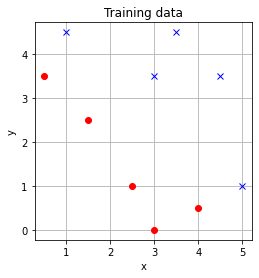

In [21]:
ax=plt.figure().add_subplot(111)
ax.set_aspect('equal')

for dot,gr in zip(train_set,train_gr):
    if gr == 0:
        plt.plot(dot[0],dot[1], 'r'+'o')
    elif gr == 1:
        plt.plot(dot[0],dot[1], 'b'+'x')

plt.title('Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.savefig('linear_separable_training_data.png')

学習をさせる為、データを　「Tensor」　の形式に変換する

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set_tensor = torch.FloatTensor(train_set).to(device)
train_gr_tensor = torch.FloatTensor(train_gr).to(device)
print(train_set_tensor)
print(train_gr_tensor)

tensor([[0.5000, 3.5000],
        [1.5000, 2.5000],
        [2.5000, 1.0000],
        [3.0000, 0.0000],
        [4.0000, 0.5000],
        [1.0000, 4.5000],
        [3.0000, 3.5000],
        [3.5000, 4.5000],
        [4.5000, 3.5000],
        [5.0000, 1.0000]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])


##2．ネットワーク構造の定義
* 使用する関数
* 層数
* 各層のニューロン数
などを定義する。

In [23]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(2, 1))
        self.layers.append(torch.nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
          x = layer(x)
        return x

model = NeuralNet().to(device)

##3．学習の為のパラメータを設定
* 損失関数 : 平均自乗誤差 (Mean Square Error)
* 最適化手法：Adam
* 学習回数 : 50000
* 学習率 : 0.01

In [24]:
learning_rate = 0.01
Loss_criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_epoch = 50000

##4．学習

train loss at 0 is 0.2974229156970978
train loss at 5000 is 0.002451191656291485
train loss at 10000 is 0.0001743776083458215
train loss at 15000 is 1.4642673704656772e-05
train loss at 20000 is 1.274302348974743e-06
train loss at 25000 is 1.1427233914673707e-07
train loss at 30000 is 1.2528831305758104e-08
train loss at 35000 is 2.895246709044841e-09
train loss at 40000 is 1.378430258824892e-09
train loss at 45000 is 8.888456082267737e-10


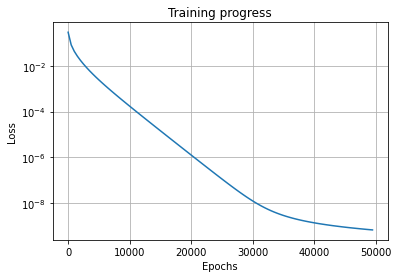

In [25]:
model.train()

graph_x = []
graph_y = []
for epoch in range(n_epoch):
    
    optimizer.zero_grad()
    train_output = model(train_set_tensor)
    
    train_loss = Loss_criterion(train_output.squeeze() , train_gr_tensor)
    if epoch%(n_epoch/10) == 0:
      print('train loss at {} is {}'.format(epoch, train_loss.item()))
    if epoch%(n_epoch/100) == 0:
      graph_x.append(epoch)
      graph_y.append(train_loss.item())

    # train_loss.backward()
    train_loss.backward(retain_graph=True)
    optimizer.step()

ax=plt.figure().add_subplot(111)
ax.set_yscale('log')
plt.title('Training progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(graph_x, graph_y)
plt.savefig('loss_function1.png')

##5．学習結果を確認する

パラメータの表示。以下の様に表示される。
```
Parameter containing:
tensor([[12.7308, 14.7038]], requires_grad=True)
Parameter containing:
tensor([-68.2612], requires_grad=True)
```
線形関数の式を λ= b + w1・x + w2・y とする時（x, y は入力。b はバイアス、w1, w2 は重み）、b=(-68.2612), w1=12.7308, w2=14.7038 である。確率的学習アルゴリズムで乱数が用いられるので、結果は毎回異なる。

In [26]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[12.5961, 14.5482]], requires_grad=True)
Parameter containing:
tensor([-67.5382], requires_grad=True)


結果のグラフ表示

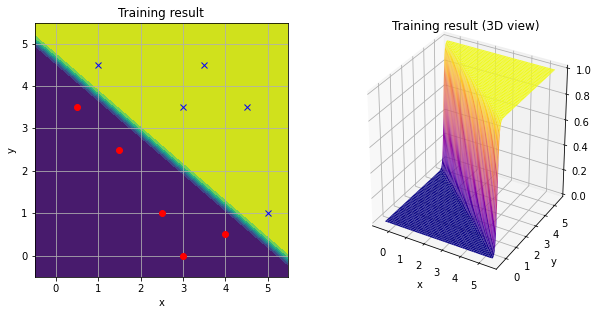

In [27]:
import numpy as np

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_aspect('equal')
plt.title('Training result')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

x = np.arange(-0.5, 5.5, 0.02)
y = np.arange(-0.5, 5.5, 0.02)
z = np.empty((y.size, x.size))

model.eval()
for j in range(y.size):
  yy = y[j]
  for i in range(x.size):
    xx = x[i]
    z[j][i] = model(torch.FloatTensor([xx,yy]))
ax1.contourf(x, y, z)
for dot,gr in zip(train_set,train_gr):
    if gr == 0:
        ax1.plot(dot[0],dot[1], 'r'+'o')
    elif gr == 1:
        ax1.plot(dot[0],dot[1], 'b'+'x')

x,y = np.meshgrid(x, y)
ax2 = fig.add_subplot(1,2,2,projection='3d')
plt.title('Training result (3D view)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
ax2.plot_surface(x, y, z, cmap='plasma')
plt.savefig('result_of_training1.png')